# Stroke Classfier
> - Gabrile Serafini
> - Marco Sousa-Poza

This Notebook discribes the computations made to find an optimal stroke classifier based on real healthcare data.

## Exploring the Data
In the following the data will be read and prepared for further use.

In [1]:
# All the necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Reading the data into a data frame
df_health = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df_health.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We see that the data contains some NaN values. If there are not too many we can delete them.

In [3]:
print("The number of NaN values for each column is:")
print(df_health.isna().sum())
print("There are {} rows in this df.".format(df_health.shape[0]))

The number of NaN values for each column is:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
There are 5110 rows in this df.


Since there are not that many NaN values we can drop them. We will also drop the id as it is not important.

In [4]:
df_health.dropna(axis=1, inplace=True)
df_health.drop('id', axis=1, inplace=True)

Next we change the nominal attributes to numbers. This is important for the more mathematical models we are going to use later on.

In [5]:
obj_df = df_health.select_dtypes(include=['object'])
for col in obj_df.columns:
    print(obj_df[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [31]:

# We again find some hidden NaN values. We can delete those:
df_health.drop(df_health[df_health['gender'] == 'Other'].index, inplace=True)
#NOTE: For now we simpy drop unknows values. Idea is to maybe infere these values
df_health.drop(df_health[df_health['smoking_status'] == 'Unknown'].index, inplace=True)

gender_dict = {'Female':1, 'Male':0}
married_dict = {'Yes':1, 'No':0}
worktype_dict = {'Private':4, 'Self-employed':3, 'children':2, 'Govt_job':1, 'Never_worked':0}
residence_dict = {'Urban':1, 'Rural':0}
smoke_dict = {'never smoked':2,'formerly smoked':1,'smokes':0}
health_numerical = df_health.replace(
    {
        'gender':gender_dict,
        'ever_married':married_dict,
        'work_type':worktype_dict,
        'Residence_type':residence_dict,
        'smoking_status':smoke_dict
    }
).values

In [52]:
y = df_health['stroke'].values
X = health_numerical[:, :-1]

## Data Vizualisation



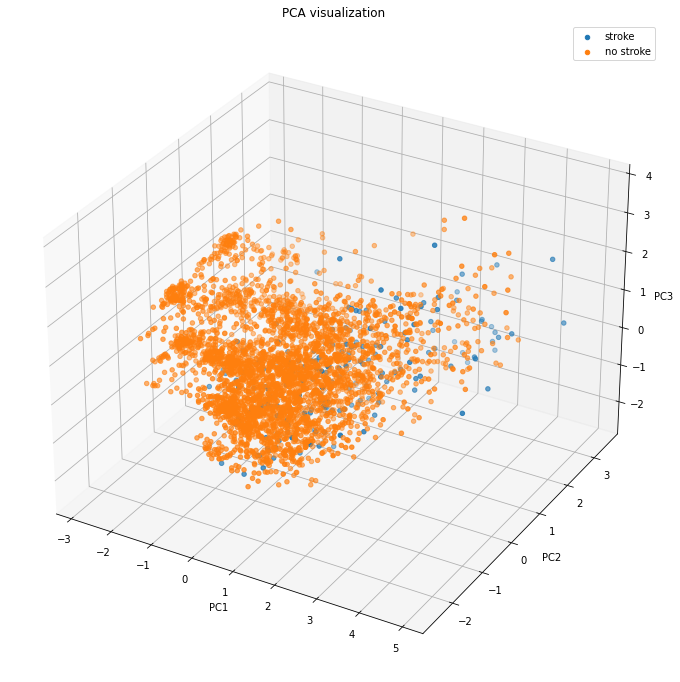

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
stc = StandardScaler()
pca = PCA()
p = Pipeline([('scaler', stc), ('pca', pca)])
health_pca = p.fit_transform(X)

# Plot PCA
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(health_pca[y==1][:,0], health_pca[y==1][:,1], health_pca[y==1][:,2], label='stroke')
ax.scatter(health_pca[y==0][:,0], health_pca[y==0][:,1], health_pca[y==0][:,2], label='no stroke')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
ax.set_title('PCA visualization')

plt.show()

We can see that the data is not well separated by the PCs. This is a indicator that the data will probably not be that well separated with a linear model. This is something we need to keep in mind when choosing hyperparameters for some of our classifiers.

## Classification
### Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import recall_score
from itertools import product
scaled_data = stc.fit_transform(X)

min_splits = [n for n in range(10, 101, 10)]
max_depth = [n for n in range(30,110,5)]
kf = RepeatedKFold(n_splits=10, n_repeats=5)

avg_errors = []
for h1, h2 in product(min_splits, max_depth):
    rfc = RandomForestClassifier(
        max_depth=h1, #h1
        n_estimators=10, # We take 50 trees, 
        criterion='entropy',
        min_samples_split=h2 #h2
    )
    errors = []
    for train, test in kf.split(X):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        rfc.fit(X_train, y_train)
        y_test_pred = rfc.predict(X_test)
        # We use recall since it is less sensitive to classification with view true classes.
        errors.append(recall_score(y_test, y_test_pred))
    errors.append(sum(errors)/len(errors))


10 30
10 35
10 40
10 45
10 50
10 55
10 60
10 65
10 70
10 75
10 80
10 85
10 90
10 95
10 100
10 105
20 30
20 35
20 40
20 45
20 50
20 55
20 60
20 65
20 70
20 75
20 80
20 85
20 90
20 95
20 100
20 105
30 30
30 35
30 40
30 45
30 50
30 55
30 60
30 65
30 70
30 75
30 80
30 85
30 90
30 95
30 100
30 105
40 30
40 35
40 40
40 45
40 50
40 55
40 60
40 65
40 70
40 75
40 80
40 85
40 90
40 95
40 100
40 105
50 30
50 35
50 40
50 45
50 50
50 55
50 60
50 65
50 70
50 75
50 80
50 85
50 90
50 95
50 100
50 105
60 30
60 35
60 40
60 45
60 50
60 55
60 60
60 65
60 70
60 75
60 80
60 85
60 90
60 95
60 100
60 105
70 30
70 35
70 40
70 45
70 50
70 55
70 60
70 65
70 70
70 75
70 80
70 85
70 90
70 95
70 100
70 105
80 30
80 35
80 40
80 45
80 50
80 55
80 60
80 65
80 70
80 75
80 80
80 85
80 90
80 95
80 100
80 105
90 30
90 35
90 40
90 45
90 50
90 55
90 60
90 65
90 70
90 75
90 80
90 85
90 90
90 95
90 100
90 105
100 30
100 35
100 40
100 45
100 50
100 55
100 60
100 65
100 70
100 75
100 80
100 85
100 90
100 95
100 100
100 105


ValueError: Argument Z must be 2-dimensional.

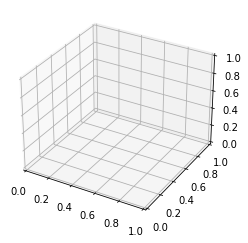

In [58]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
U, V = np.meshgrid(min_splits, max_depth)
ax = fig.gca(projection='3d')
ax.plot_surface(U, V, np.array(avg_errors))
plt.show()